Лабораторную работу выполнили Спасюк Мария и Родионцева Ирина, 22ПМИ-1

1. Скачиваем датасет

In [ ]:
!kaggle datasets download gpiosenka/cards-image-datasetclassification
!unzip cards-image-datasetclassification

In [ ]:
!pip install pytorch_lightning -q

2. Импортируем необходимые библиотеки

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torchvision.models import resnet18
import wandb
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

В классе Transforms реализована предобработка данных для корректной работы Albumentation. Далее прописываем действия для аугментации

In [5]:
class Transforms:
    def __init__(self, transform):
        self.transforms = transform

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

In [ ]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(height=64, width=64),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.Resize(height=64, width=64),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

Считываем датасет и применяем аугментацию

In [7]:
train_dataset = ImageFolder('train', transform = Transforms(train_transform))
val_dataset = ImageFolder('valid', transform = Transforms(val_transform))
test_dataset = ImageFolder('test', transform = Transforms(val_transform))
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 2, persistent_workers = True )
val_dataloader = DataLoader(val_dataset, batch_size = 32, shuffle = False, num_workers = 2, persistent_workers = True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False, num_workers = 2, persistent_workers = True)

Посмотрим на картиночки

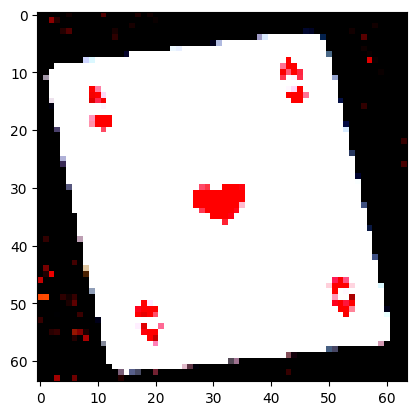

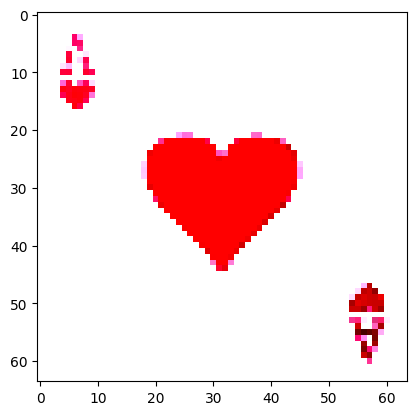

In [8]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[10].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[13].permute(1, 2, 0))
    plt.show()
    break

Выполним файнтюнинг модели ResNet18

In [9]:
class MyNet(torch.nn.Module):
    def __init__(self, pretrained: bool = False) -> None:
        super().__init__()
        self.model = resnet18(pretrained=pretrained, num_classes = 53)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x) -> torch.Tensor:
        preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.acc = accuracy(torch.argmax(preds, dim=-1), target, task="multiclass", num_classes=53)
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", self.acc, prog_bar=True)
        return loss

    def get_accuracy(self, reset=True):
        return self.acc

Напишем Pytorch lightning module для использования фич pytorch lightning

In [10]:
class MyModule(pl.LightningModule):
    def __init__(self, model) -> None:
        super().__init__()
        self.model = model
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.loss = nn.CrossEntropyLoss()


    def forward(self, x) -> torch.Tensor:
        preds = self.model(x)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.acc = accuracy(torch.argmax(preds, dim=-1), target, task="multiclass", num_classes=53)
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", self.acc , prog_bar=True)
        return loss

    def get_accuracy(self, reset=True):
        return self.acc

In [ ]:
wandb.init(group="experiment_2")

In [ ]:
wandb_logger = WandbLogger(log_model='all')


model = MyNet(pretrained = False)
module = MyModule(model = model)

In [ ]:
trainer = pl.Trainer(logger = wandb_logger, strategy = "ddp_notebook", max_epochs = 12, accelerator='gpu',)
trainer.fit(module, train_dataloader, val_dataloader)

In [ ]:
wandb.finish()

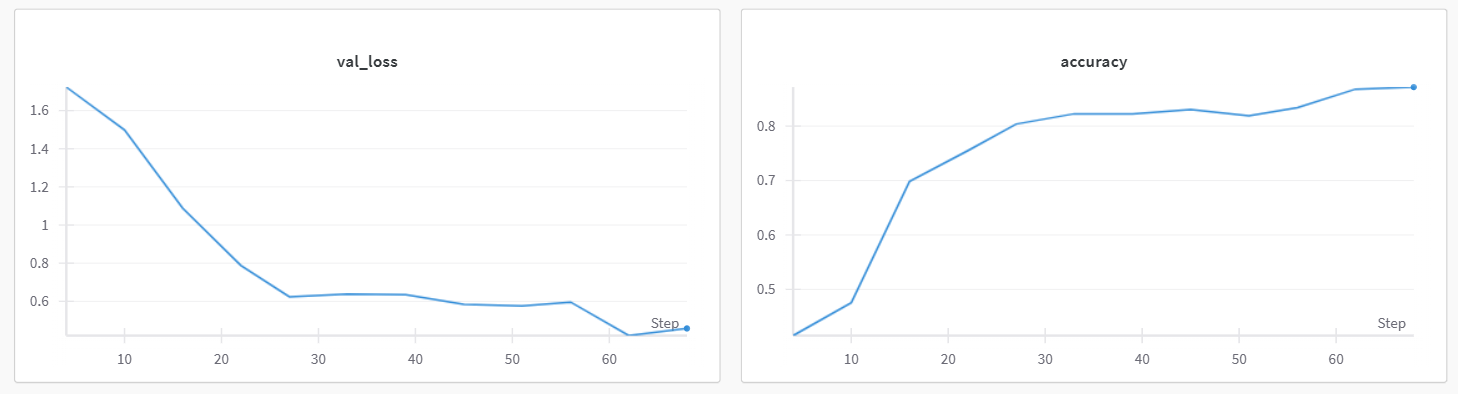

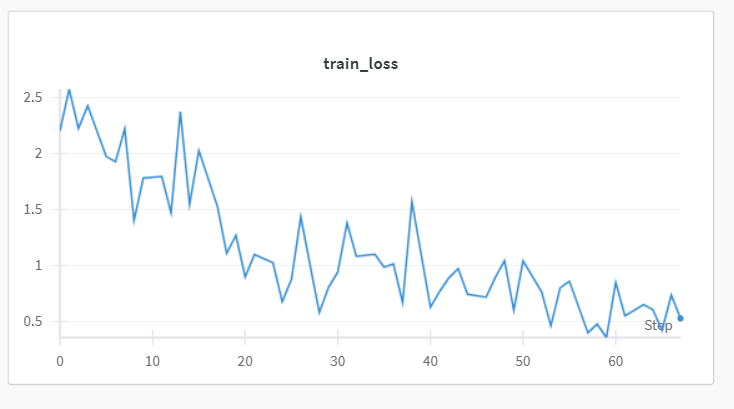

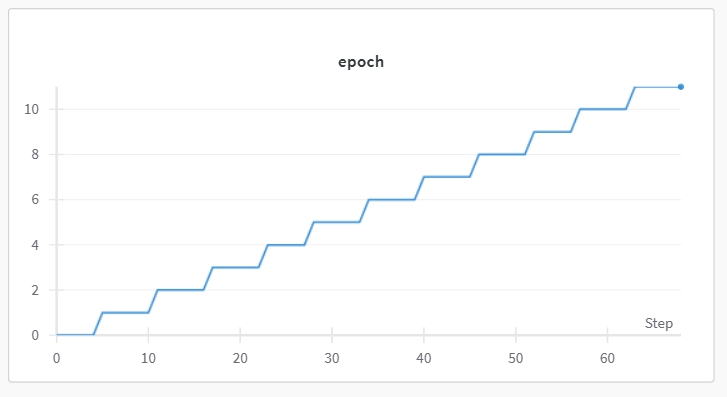

Посчитаем Accuracy на тестовых данных

In [35]:
model.eval()
predicted_classes = torch.Tensor([])
true_classes = torch.Tensor([])

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images, labels = images, labels
        pred = model.forward(images)
        pred_classes = torch.argmax(pred, dim=-1)
        predicted_classes = torch.cat((predicted_classes, pred_classes), 0)
        true_classes = torch.cat((true_classes, labels), 0)
print(f"\nAccuracy на тестовых данных {accuracy_score(predicted_classes.cpu().detach().numpy(), true_classes.cpu().detach().numpy())}")

100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


Accuracy на тестовых данных 0.8754716981132076
